# Image Augmentation Using Albumentations for Images with Bounded Boxes (YOLO format)

In this notebook, we are focusing on image preprocessing and data augmentation, specifically for object detection tasks that use the YOLO (You Only Look Once) format for bounding box coordinates.

This notebook contains several Python functions that perform various tasks:

1. Conversion of bounding box coordinates from YOLO format to OpenCV format.
2. Plotting of images with the bounding boxes and their associated labels.
3. Application of various transformations to images and their bounding boxes, including cropping and flipping.
4. Generation of new, transformed images and their corresponding bounding boxes.

These functions are useful for preprocessing and augmenting your image datasets, enhancing the diversity and quantity of your training data, and thus, improving the performance and robustness of your object detection models.

This notebook also includes examples of how to use these functions, demonstrating how to read images and their bounding box coordinates, apply the transformations, and save the transformed images and updated bounding boxes.

## Importing the Required Packages

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import albumentations as A

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd

Mounted at /content/gdrive
/content


##Plotting the image and box

The below code provides functions to convert YOLO (You Only Look Once) box coordinates to OpenCV box coordinates and plot these boxes on images.

1. `yoloFormattocv(x1, y1, x2, y2, H, W)`: This function converts YOLO box coordinates to OpenCV box coordinates. YOLO defines a bounding box based on its center coordinates (x1, y1) and its width and height (x2, y2), where all values are normalized to be between 0 and 1 relative to the image's width and height. OpenCV defines a bounding box by the coordinates of its top-left corner and its bottom-right corner. The function multiplies the normalized YOLO coordinates by the actual image width (W) and height (H) to get the pixel values, then calculates the OpenCV coordinates.

2. `box_color` and `box_name` dictionaries: These dictionaries define the colors and names of different types of boxes, which are represented by numbers from 0 to 13.

3. `plot_img_box_orginial(img, yolo_coords)`: This function takes an image and a list of YOLO box coordinates. It converts these coordinates to OpenCV format using `yoloFormattocv()`, then uses matplotlib's `imshow()`, `add_patch()`, and `annotate()` functions to display the image and draw and label the boxes.

4. `plot_img_box_transformed(img, box, label)`: This function is similar to `plot_img_box_orginial()`, but it takes separate lists of boxes and labels instead of a single list that combines them. It combines these lists into a single list, then proceeds as `plot_img_box_orginial()` does.

In [ ]:
# Convert box coordinate from yolo to cv
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    cv = []
    cv.append(center_x - (bbox_width / 2))
    cv.append(center_y - (bbox_height / 2))
    cv.append(center_x + (bbox_width / 2))
    cv.append(center_y + (bbox_height / 2))
    return [int(v) for v in cv]

In [ ]:
# defining box name and color
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}

In [ ]:
#plotting the image with the box
def plot_img_box_orginial(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  plt.imshow(img)
  for row in yolo_coords:
    [x1,y1,x2,y2] = yoloFormattocv(float(row[1]),float(row[2]),float(row[3]),float(row[4]),image_height, image_width)
    plt.gca().add_patch(Rectangle((x1,y1),abs(x2-x1),abs(y2-y1), edgecolor=box_color[int(row[0])], facecolor='none', lw=1))
    plt.annotate(box_name[int(row[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(row[0])], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

In [ ]:
#plotting the image with the box

def plot_img_box_transformed(img, box, label):
  image_height, image_width = img.shape[:2]
  plt.imshow(img)
  combined=box
  for i in range(len(label)):
    combined[i] = (label[i],)+ box[i]
  
  for row in combined:
    [x1,y1,x2,y2] = yoloFormattocv(float(row[1]),float(row[2]),float(row[3]),float(row[4]),image_height, image_width)
    plt.gca().add_patch(Rectangle((x1,y1),abs(x2-x1),abs(y2-y1), edgecolor=box_color[row[0]], facecolor='none', lw=1))
    plt.annotate(box_name[row[0]], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[row[0]], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

#Only Cropping

The below code includes a function `yolo_transform_crop(img, yolo_coords)`, which is used to apply transformations to the input image and the bounding boxes of objects in the image. It also includes test cases to demonstrate its use.

1. `yolo_transform_crop(img, yolo_coords)`: This function performs transformations on an image and the corresponding bounding boxes. The bounding box coordinates are provided in YOLO format. The function first extracts the height and width of the image. It then loops over the coordinates, extracting the class ID and the min/max x and y values for each bounding box, and storing them into separate lists. It uses Albumentations (`A`) library to define a transformation pipeline that includes `RandomSizedBBoxSafeCrop` which randomly crops the image while ensuring that all bounding boxes are kept intact (with an erosion rate of 0.5), and applies this transformation to the image and bounding boxes. The transformed image, bounding boxes, and class IDs are returned as a dictionary.

2. Test 1 & 2: These test cases demonstrate how to use the `yolo_transform_crop` function. In each test case, it reads the YOLO coordinates from a text file and an image from a specified path. It then applies the `yolo_transform_crop` function to the image and YOLO coordinates. The transformed image, bounding boxes, and class IDs are extracted from the resulting dictionary. Finally, it uses the previously defined `plot_img_box_orginial` and `plot_img_box_transformed` functions to display the original and transformed images with their bounding boxes. The test cases are identical except for the image and YOLO coordinates used.

## RandomSizedBBoxSafeCrop

In [ ]:
def yolo_transform_crop(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  yolo_box = []
  class_labels =[]
  for a in yolo_coords:
    class_id, xmin, xmax, ymin, ymax = a
    b = [xmin, xmax, ymin, ymax]
    yolo_box.append(b)
    label = int(class_id)
    class_labels.append(label)
  
  #you can add more functions from Albumentations here and also modify the erosion rate
  transform = A.Compose([A.RandomSizedBBoxSafeCrop(width=image_width, height=image_height, erosion_rate=0.5)
  ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
  transformed = transform(image=img, bboxes=yolo_box, category_ids=class_labels)
  
  return transformed

##Test 1

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0002_0005.txt"
img_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0002_0005.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path, "r") as f:
    yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img = cv2.imread(img_path)

In [ ]:
a = yolo_transform_crop(img, yolo_coords)

In [ ]:
image= a['image']
box = a['bboxes']
label = a['category_ids']

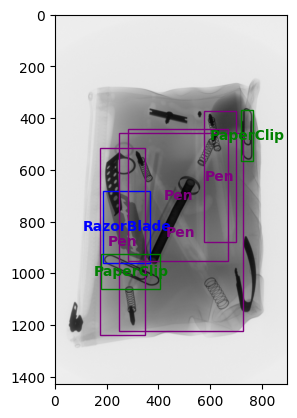

In [ ]:
plot_img_box_orginial(img, yolo_coords)

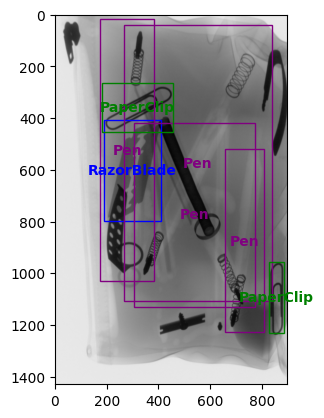

In [ ]:
plot_img_box_transformed(image, box, label)

## Test 2

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0015_0004.txt"
img_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0015_0004.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path2, "r") as f:
    yolo_coords2 = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img2 = cv2.imread(img_path2)

In [ ]:
a2 = yolo_transform_crop(img2, yolo_coords2)

In [ ]:
image2= a2['image']
box2 = a2['bboxes']
label2 = a2['category_ids']

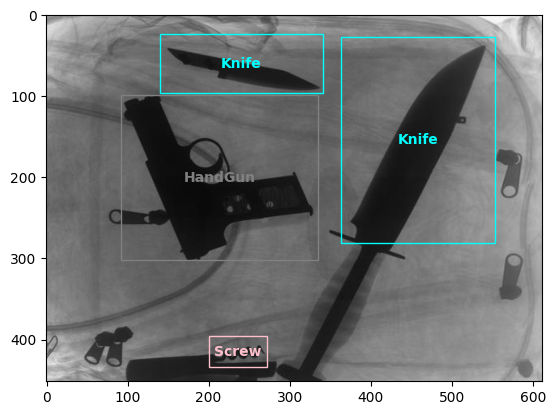

In [ ]:
plot_img_box_orginial(img2, yolo_coords2)

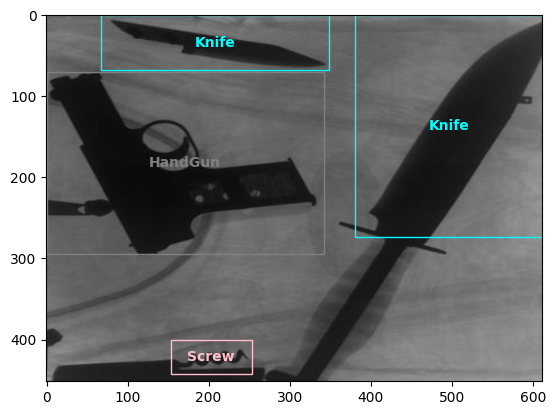

In [ ]:
plot_img_box_transformed(image2, box2, label2)

## Transforming images from folder path

The `generate_cropped_image` function takes in the paths of an image folder, an annotation folder, a save image path, and a save annotation path as input. It processes all images and their corresponding annotations in the image and annotation folders, applying a cropping transformation to the images and their bounding boxes. The transformed images and their updated bounding boxes are then saved to the specified save paths.

Here is a detailed step-by-step description:

1. It first obtains a list of image and annotation file names from the given image and annotation folder paths.

2. It then iterates over each image and its corresponding annotation. For each pair, it reads the image and annotation (which contains YOLO coordinates) from their respective files.

3. It applies the `yolo_transform_crop` function to the image and its YOLO coordinates. This function returns a dictionary containing the transformed image and its updated bounding boxes.

4. It saves the transformed image to the specified save image path, prepending the file name with 'cropped_0.5_'. (You can modify the name of the image and annotations; please ensure that they remain same though)

5. It then processes the bounding boxes and their corresponding labels (class IDs). It first combines the labels and bounding boxes into one list. Then, it formats each combined label and bounding box as a string and removes any commas and parentheses.

6. Lastly, it saves these formatted strings to a text file in the specified save annotation path. Each string is written on a new line, except for the last string, which is written without a trailing newline to avoid an empty row at the end of the file.

This function can be used to preprocess a batch of images and their annotations for object detection tasks, particularly for models that use the YOLO (You Only Look Once) format. It handles both the image transformations and the corresponding updates to the bounding boxes.

In [3]:
def generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path):
  
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
  annotation_list = [i for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))]

  # Loop through each image
  count = 0
  for img_name, annotation_name in zip(image_list, annotation_list):
    count = count + 1
    full_path_img = image_folder_path + "/" + img_name
    full_path_coords = annotation_folder_path + "/" + annotation_name

    #opening image and txt file
    img = cv2.imread(full_path_img)
    with open(full_path_coords, "r") as f:
      yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]
  
    #applying the transformation
    cropped = yolo_transform_crop(img, yolo_coords)
    images = cropped['image']

    #saving the image
    #you can change the name of the transformed image here
    cv2.imwrite(save_img_pth + "/" + 'cropped_0.5_' + img_name, images)

    #creating combined coordinates with labels
    box = cropped['bboxes']
    label = cropped['category_ids']
    combined=box
    for i in range(len(label)):
      combined[i] = str((label[i],)+ box[i])
      combined[i] = combined[i].replace(",", "")
      combined[i] = combined[i].replace("(", "")
      combined[i] = combined[i].replace(")", "")

    #you can change the name of the transformed annotation file here (please make sure that the name of image and annotation file remain same)
    file_name = save_annotation_path + "/" +'cropped_0.5_'+ annotation_name
    with open(file_name, 'w') as fp:
      for i in range(len(combined)):
        if i < (len(combined)-1):
          fp.write(combined[i]+"\n") # add break line for items not the last one
        else:
          fp.write(combined[i]) # no break line for last item (avoid empty row)

## Saving Images

In [2]:
#modify the folder names as needed
#get images
image_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels"

#save images
save_img_pth = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_original_0.5/images"
save_annotation_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_original_0.5/labels"

In [ ]:
generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path)

#Cropping + Vertical Flip

The function `yolo_transform2(img, yolo_coords)` almost same as the above function; except we are doing cropping + vertical flip of the images here. This function is used to apply a sequence of transformations to an input image and its associated bounding boxes (YOLO format). Here's a detailed description:

1. The function first extracts the height and width of the image. It then loops over the coordinates, extracting the class ID and the min/max x and y values for each bounding box, storing these into separate lists.

2. It uses the Albumentations (`A`) library to define a transformation pipeline that includes `VerticalFlip` and `RandomSizedBBoxSafeCrop`. `VerticalFlip` flips the image vertically with a probability of 1 (i.e., always). `RandomSizedBBoxSafeCrop` randomly crops the image while ensuring that all bounding boxes are kept intact (with an erosion rate of 0.5).

3. The transformation pipeline is then applied to the image and bounding boxes. 

4. The function returns the transformed image, bounding boxes, and class IDs as a dictionary.

## RandomSizedBBoxSafeCrop+Vertical Flip



In [ ]:
def yolo_transform2(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  yolo_box = []
  class_labels =[]
  for a in yolo_coords:
    class_id, xmin, xmax, ymin, ymax = a
    b = [xmin, xmax, ymin, ymax]
    yolo_box.append(b)
    label = int(class_id)
    class_labels.append(label)
  
  transform = A.Compose([A.VerticalFlip(p=1), A.RandomSizedBBoxSafeCrop(width=image_width, height=image_height, erosion_rate=0.5)
  ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
  transformed = transform(image=img, bboxes=yolo_box, category_ids=class_labels)
  
  return transformed

##Test 1

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0002_0005.txt"
img_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0002_0005.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path, "r") as f:
    yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img = cv2.imread(img_path)

In [ ]:
a = yolo_transform2(img, yolo_coords)

In [ ]:
image= a['image']
box = a['bboxes']
label = a['category_ids']

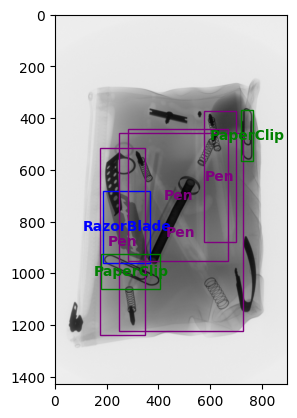

In [ ]:
plot_img_box_orginial(img, yolo_coords)

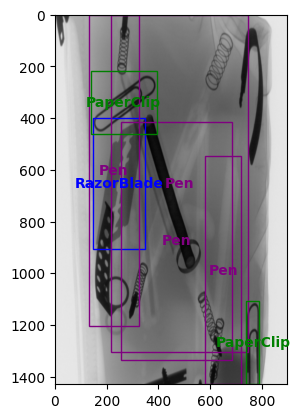

In [ ]:
plot_img_box_transformed(image, box, label)

## Test 2

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0015_0004.txt"
img_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0015_0004.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path2, "r") as f:
    yolo_coords2 = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img2 = cv2.imread(img_path2)

In [ ]:
a2 = yolo_transform2(img2, yolo_coords2)

In [ ]:
image2= a2['image']
box2 = a2['bboxes']
label2 = a2['category_ids']

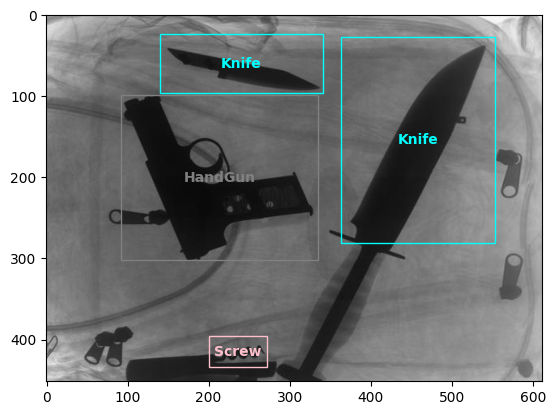

In [ ]:
plot_img_box_orginial(img2, yolo_coords2)

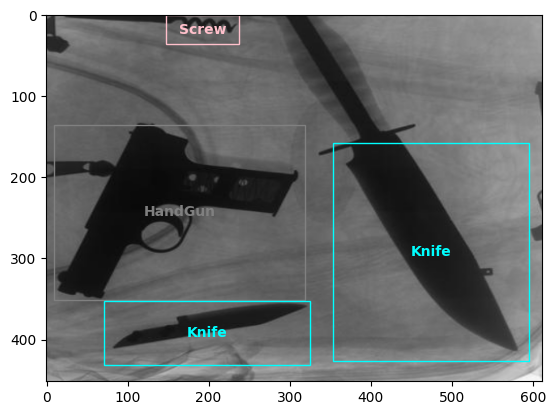

In [ ]:
plot_img_box_transformed(image2, box2, label2)

## Transforming images from folder path

In [ ]:
def generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path):
  
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
  annotation_list = [i for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))]

  # Loop through each image
  count = 0
  for img_name, annotation_name in zip(image_list, annotation_list):
    count = count + 1
    full_path_img = image_folder_path + "/" + img_name
    full_path_coords = annotation_folder_path + "/" + annotation_name

    #opening image and txt file
    img = cv2.imread(full_path_img)
    with open(full_path_coords, "r") as f:
      yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]
  
    #applying the transformation
    cropped = yolo_transform2(img, yolo_coords)
    images = cropped['image']

    #saving the image
    #you can change the name of the transformed image here
    cv2.imwrite(save_img_pth + "/" + 'cropped2_0.5_' + img_name, images)

    #creating combined coordinates with labels
    box = cropped['bboxes']
    label = cropped['category_ids']
    combined=box
    for i in range(len(label)):
      combined[i] = str((label[i],)+ box[i])
      combined[i] = combined[i].replace(",", "")
      combined[i] = combined[i].replace("(", "")
      combined[i] = combined[i].replace(")", "")

    #you can change the name of the transformed annotation file here (please make sure that the name of image and annotation file remain same)
    file_name = save_annotation_path + "/" +'cropped2_0.5_'+ annotation_name
    with open(file_name, 'w') as fp:
      for i in range(len(combined)):
        if i < (len(combined)-1):
          fp.write(combined[i]+"\n") # add break line for items not the last one
        else:
          fp.write(combined[i]) # no break line for last item (avoid empty row)

## Saving Images

In [1]:
#modify the folder names as needed
#get images
image_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels"

#save images
save_img_pth = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_flips_0.5/images"
save_annotation_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_flips_0.5/labels"

In [ ]:
generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path)

#Cropping + Vertical Flip + Horizontal Flip

The `yolo_transform3(img, yolo_coords)` function applies a series of transformations to an input image and its corresponding bounding boxes, provided in YOLO format.

Here's a detailed breakdown:

1. It starts by extracting the height and width of the image. It then iterates over the provided YOLO coordinates, extracting the class ID and the min/max x and y values for each bounding box. These are stored in separate lists.

2. Using the Albumentations (`A`) library, a transformation pipeline is defined that includes `VerticalFlip`, `HorizontalFlip`, and `RandomSizedBBoxSafeCrop`. `VerticalFlip` and `HorizontalFlip` flip the image vertically and horizontally, respectively, with a probability of 1 (i.e., always). `RandomSizedBBoxSafeCrop` randomly crops the image while ensuring that all bounding boxes remain intact, with an erosion rate of 0.5.

3. This transformation pipeline is then applied to the image and bounding boxes.

4. Finally, the function returns the transformed image, bounding boxes, and class IDs as a dictionary.

## RandomSizedBBoxSafeCrop+Vertical Flip+Horizontal Flip



In [ ]:
def yolo_transform3(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  yolo_box = []
  class_labels =[]
  for a in yolo_coords:
    class_id, xmin, xmax, ymin, ymax = a
    b = [xmin, xmax, ymin, ymax]
    yolo_box.append(b)
    label = int(class_id)
    class_labels.append(label)
  
  transform = A.Compose([A.VerticalFlip(p=1), A.HorizontalFlip(p=1), A.RandomSizedBBoxSafeCrop(width=image_width, height=image_height, erosion_rate=0.5)
  ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
  transformed = transform(image=img, bboxes=yolo_box, category_ids=class_labels)
  
  return transformed

##Test 1

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0002_0005.txt"
img_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0002_0005.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path, "r") as f:
    yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img = cv2.imread(img_path)

In [ ]:
a = yolo_transform3(img, yolo_coords)

In [ ]:
image= a['image']
box = a['bboxes']
label = a['category_ids']

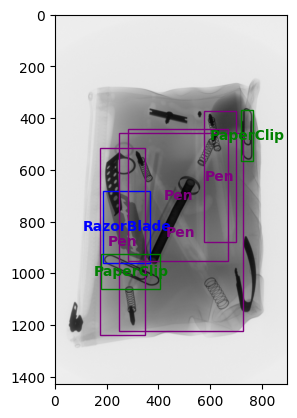

In [ ]:
plot_img_box_orginial(img, yolo_coords)

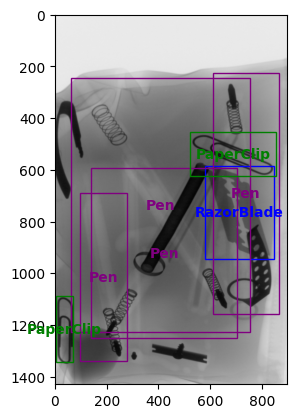

In [ ]:
plot_img_box_transformed(image, box, label)

## Test 2

In [ ]:
# example usage (you can modify the image and annotation path here)
txt_file_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0015_0004.txt"
img_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0015_0004.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path2, "r") as f:
    yolo_coords2 = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img2 = cv2.imread(img_path2)

In [ ]:
a2 = yolo_transform3(img2, yolo_coords2)

In [ ]:
image2= a2['image']
box2 = a2['bboxes']
label2 = a2['category_ids']

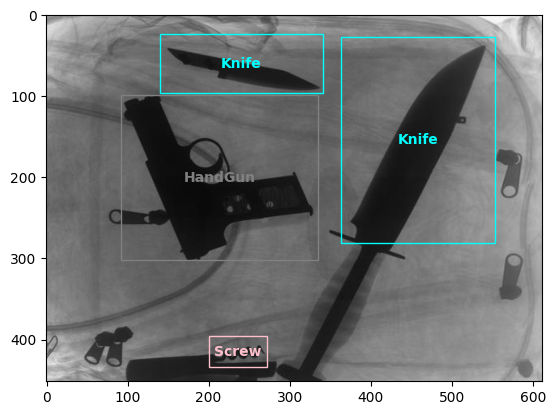

In [ ]:
plot_img_box_orginial(img2, yolo_coords2)

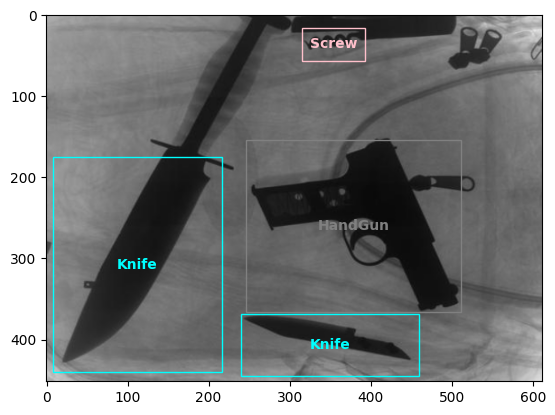

In [ ]:
plot_img_box_transformed(image2, box2, label2)

## Transforming images from folder path

In [ ]:
def generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path):
  
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
  annotation_list = [i for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))]

  # Loop through each image
  count = 0
  for img_name, annotation_name in zip(image_list, annotation_list):
    count = count + 1
    full_path_img = image_folder_path + "/" + img_name
    full_path_coords = annotation_folder_path + "/" + annotation_name

    #opening image and txt file
    img = cv2.imread(full_path_img)
    with open(full_path_coords, "r") as f:
      yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]
  
    #applying the transformation
    cropped = yolo_transform3(img, yolo_coords)
    images = cropped['image']

    #saving the image
    #you can change the name of the transformed image here
    cv2.imwrite(save_img_pth + "/" + 'cropped3_0.5_' + img_name, images)

    #creating combined coordinates with labels
    box = cropped['bboxes']
    label = cropped['category_ids']
    combined=box
    for i in range(len(label)):
      combined[i] = str((label[i],)+ box[i])
      combined[i] = combined[i].replace(",", "")
      combined[i] = combined[i].replace("(", "")
      combined[i] = combined[i].replace(")", "")

    file_name = save_annotation_path + "/" +'cropped3_0.5_'+ annotation_name
    with open(file_name, 'w') as fp:
      for i in range(len(combined)):
        if i < (len(combined)-1):
          fp.write(combined[i]+"\n") # add break line for items not the last one
        else:
          fp.write(combined[i]) # no break line for last item (avoid empty row)

## Saving Images

In [ ]:
#modify the folder names as needed
#get images
image_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels"

#save images
save_img_pth = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_flips_0.5/images"
save_annotation_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/Augmented Images/cropped_flips_0.5/labels"

In [ ]:
generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path)